In [2]:
import os
from pprint import pprint

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_geometric as pyg
from torch.nn import functional as F
from torch_geometric.transforms import Compose, KNNGraph, RadiusGraph, ToSparseTensor

from lesion_gnn.datasets import DDR, Aptos, LESIONSArgs, SIFTArgs
from lesion_gnn.transforms import GaussianDistance
from lesion_gnn.utils import Config

In [3]:
# if in "notebooks" directory, move to parent directory
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir("..")
print(os.getcwd())

/workspaces/DRG-NET


In [4]:
config_path = "configs/ddr_aptos_lesions.yaml"
config = Config.parse_yaml(config_path)
pprint(config.model_dump())

{'batch_size': 5000,
 'dataset': {'distance_sigma_px': 22.0,
             'feature_layer': 5,
             'features_reduction': 'mean',
             'name': 'aptos-ddr',
             'num_keypoints': None,
             'reinterpolation': (512, 512),
             'root_aptos': 'data/aptos',
             'root_ddr': 'data/DDR',
             'sift_sigma': None,
             'split': (0.8, 0.2),
             'which_features': 'encoder'},
 'max_epochs': 500,
 'model': {'compile': False,
           'conv_hidden_dims': (64, 64),
           'gnn_hidden_dim': 110,
           'loss_type': 'CE',
           'lr': 0.01,
           'num_layers': 4,
           'optimizer_algo': 'adamw',
           'sortpool_k': 56,
           'weight_decay': 0.05},
 'project_name': 'Aptos-GNN',
 'seed': 42,
 'tag': 'LESIONS'}


In [5]:
# transform = Compose(
#     [
#         RadiusGraph(3 * config.dataset.distance_sigma_px, loop=True),
#         GaussianDistance(sigma=config.dataset.distance_sigma_px),
#     ]
# )
transform = KNNGraph(k=4)

kwargs = LESIONSArgs(
    which_features=config.dataset.which_features,
    feature_layer=config.dataset.feature_layer,
    features_reduction="mean",
)
# dataset = Aptos(root=config.dataset.root_aptos, transform=transform, pre_transform_kwargs=kwargs)

dataset = DDR(
    root=config.dataset.root_ddr,
    transform=transform,
    variant="train",
    pre_transform_kwargs=kwargs,
)

[]

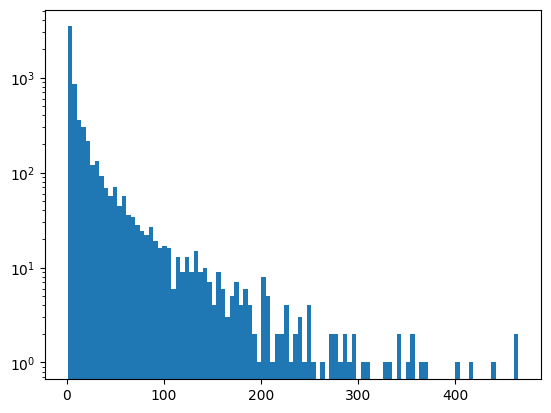

In [6]:
# number of nodes histogram
num_nodes = [d.num_nodes for d in dataset]
_ = plt.hist(num_nodes, bins=100)
plt.semilogy()

In [7]:
good_examples = [d for d in dataset if d.num_nodes > 100 and d.y == 4]

In [8]:
len(good_examples)

65

In [9]:
from matplotlib.colors import LinearSegmentedColormap

In [10]:
from fundus_lesions_toolkit.models import segment
from fundus_lesions_toolkit.constants import DEFAULT_COLORS, LESIONS
from fundus_lesions_toolkit.utils.images import open_image, autofit_fundus_resolution
from fundus_lesions_toolkit.utils.visualization import plot_image_and_mask

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


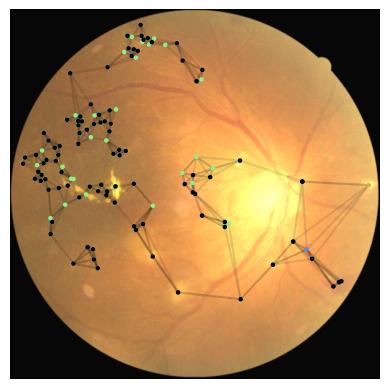

In [62]:
d = good_examples[3]
name = d.name
img = cv2.imread(f"data/DDR/raw/train/{name}.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, _ = autofit_fundus_resolution(img, 512)
# img = torch.from_numpy(img).permute(2, 0, 1).float().unsqueeze(0) / 255
# img = F.interpolate(img, size=(512, 512), mode="bilinear", align_corners=False)
# img = img.squeeze().permute(1, 2, 0).numpy()


def plot(ax, img, pos, edge_index=None, c=None, *, mask: float | None = None):
    ax.imshow(img)

    if edge_index is not None:
        for i, j in edge_index.t().tolist():
            ax.plot([pos[i, 0], pos[j, 0]], [pos[i, 1], pos[j, 1]], "k-", alpha=0.1)

    c = "g" if c is None else c
    cmap = LinearSegmentedColormap.from_list("default", DEFAULT_COLORS)
    ax.scatter(pos[:, 0], pos[:, 1], c=c, s=5, cmap=cmap, zorder=10)

    if mask is not None:
        # mask out a proportion ``mask`` of the nodes
        mask = np.random.rand(len(pos)) < mask
        ax.scatter(pos[:, 0], pos[:, 1], c="k", s=5, zorder=11, alpha=mask)


fig, ax = plt.subplots(1, 1)
# ax[0].imshow(img)
plot(ax, img, d.pos, d.edge_index, d.x[:, -1].int(), mask=0.8)
ax.set_axis_off()

# save images separately
plt.savefig("lesions_graph.png", bbox_inches="tight", pad_inches=0, dpi=500)

In [12]:
img.shape

(512, 512, 3)

/opt/conda/lib/python3.10/site-packages/fundus_lesions_toolkit/models/segmentation.py:236: UserWarning: Setting dropout to 0.2
  warnings.warn(f"Setting dropout to {initial_value}")


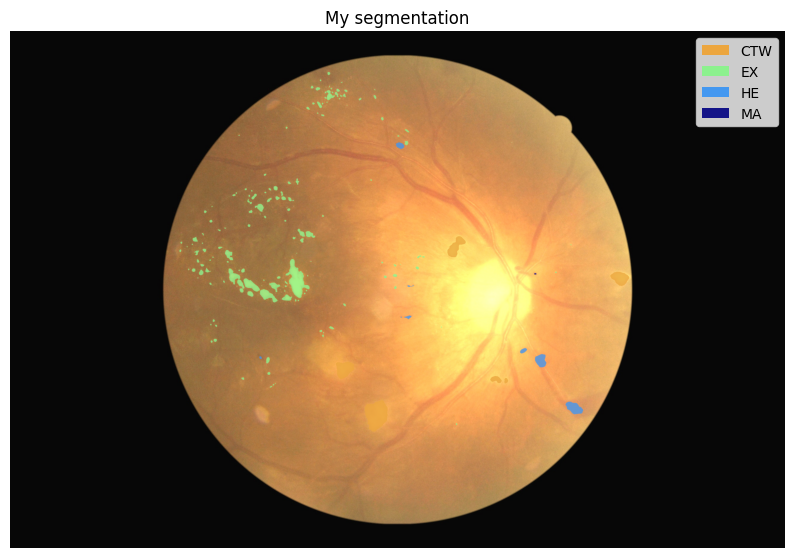

In [13]:
img = open_image(f"data/DDR/raw/train/{name}.jpg")
labelMap = segment(img, device="cuda", autofit_resolution=False, reverse_autofit=False)
plot_image_and_mask(img, labelMap, alpha=0.8, title="My segmentation", colors=DEFAULT_COLORS, labels=LESIONS)

# save image
fig = plt.gcf()
fig.savefig("lesions_segmentation.png", bbox_inches="tight", pad_inches=0, dpi=500)

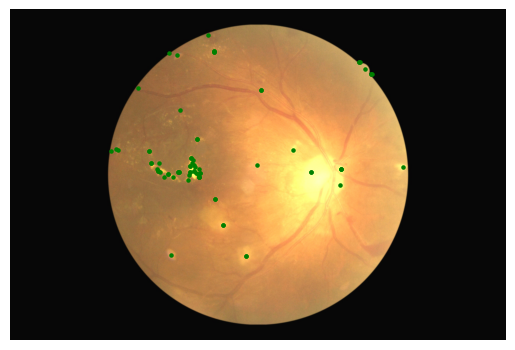

In [43]:
import cv2

num_keypoints = 50
sigma = 1.6
# sift = cv2.SIFT_create(nfeatures=num_keypoints, contrastThreshold=0, sigma=sigma)
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(img, None)

pos = np.array([k.pt for k in kp])
sizes = np.array([k.size for k in kp])
plt.imshow(img)
# plt.scatter(pos[:, 0], pos[:, 1], s=sizes, c="r", alpha=0.2, edgecolors="k")
plt.scatter(pos[:, 0], pos[:, 1], s=5, c="g", alpha=1)
plt.axis("off")
plt.savefig("sift.png", bbox_inches="tight", pad_inches=0, dpi=500)

/tmp/ipykernel_996472/2433268530.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(pos[:, 0], pos[:, 1], c=c, s=5, cmap=cmap, zorder=10)


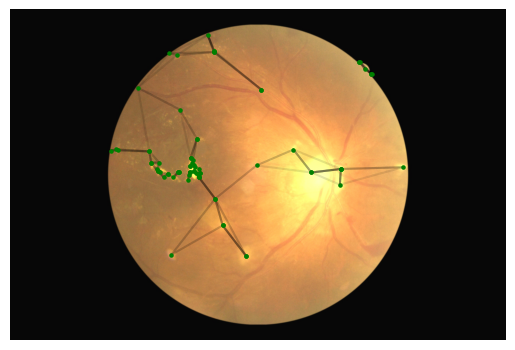

In [45]:
from torch_geometric.data import Data

data = Data(pos=torch.from_numpy(pos), x=torch.from_numpy(des))
data = transform(data)

fig, ax = plt.subplots(1, 1)
plot(ax, img, data.pos, data.edge_index)
ax.set_axis_off()
plt.savefig("sift_graph.png", bbox_inches="tight", pad_inches=0, dpi=500)